In [ ]:
from google.colab import drive
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


**Processing data**

In [ ]:
file_path = '/content/drive/My Drive/CVX/svm_train.txt'

data = np.loadtxt(file_path, skiprows=1)

labels = data[:, 2]
features = data[:, :2]

print(features.shape)

(863, 2)


In [ ]:
# Soft-margin SVM
def soft_margin_svm(X, y, C):
    n, m = X.shape
    w = cp.Variable(m)
    b = cp.Variable()
    xi = cp.Variable(n)

    objective = cp.Minimize(0.5 * cp.norm(w)**2 + C * cp.sum(xi))
    constraints = [cp.multiply(y, (X @ w + b)) >= 1 - xi, xi >= 0]
    prob = cp.Problem(objective, constraints)

    prob.solve()

    return w.value, b.value

In [ ]:
# Set regularization parameter C
C = 1.0

# Perform soft-margin SVM
weights, bias = soft_margin_svm(features, labels, C)

# Print the results
print("Weights:", weights)
print("Bias:", bias)

Weights: [-1.00209063  3.64672864]
Bias: -1.8672371699699344


**Visualization**

In [ ]:
def plot(X, y, weights, bias):
    plt.figure(figsize=(8, 6))

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k', marker='.', s=80, label='Data Points')

    x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
    y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = (np.dot(np.c_[xx.ravel(), yy.ravel()], weights) + bias).reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    plt.title('Soft-margin SVM Classification Result')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

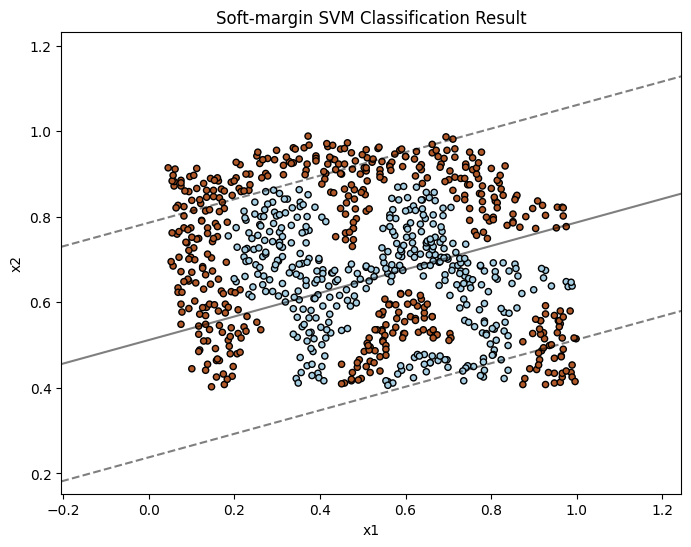

In [ ]:
plot(features, labels, weights, bias)

To derive the dual formulation of the soft-margin SVM, we start with the Lagrangian formulation of the primal soft-margin SVM problem:

$$
L(w, b, \xi, \alpha, \beta) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i - \sum_{i=1}^{N} \alpha_i \left(y_i (w^T x_i + b) - 1 + \xi_i\right) - \sum_{i=1}^{N} \beta_i \xi_i
$$

where:
- $w$ is the weight vector,
- $b$ is the bias term,
- $\xi_i$ are slack variables,
- $\alpha_i$ and $\beta_i$ are Lagrange multipliers,
- $C$ is the regularization parameter,
- $x_i$ are the feature vectors,
- $y_i$ are the class labels.

The primal problem is then to minimize this Lagrangian subject to the constraints:

$$
\min_{w, b, \xi} \max_{\alpha, \beta} L(w, b, \xi, \alpha, \beta)
$$

Now, to derive the dual formulation, we first find the partial derivatives of \(L\) with respect to \(w\), \(b\), and \(\xi_i\), set them equal to zero, and substitute them back into the Lagrangian.

After some algebraic manipulations, the dual formulation can be written as:

$$
\max_{\alpha} \min_{w, b, \xi} L(w, b, \xi, \alpha) = \max_{\alpha} \left[ -\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j x_i^T x_j + \sum_{i=1}^{N} \alpha_i \right]
$$

subject to the constraints:

$$
0 \leq \alpha_i \leq C, \quad \sum_{i=1}^{N} \alpha_i y_i = 0
$$

Thus the dual formulation for the soft-margin SVM is :

$$
\max_{\alpha} \left[ \sum_{i=1}^{N} \alpha_i-\frac{1}{2C} \alpha^T Y(XX^T)Y\alpha \right]
$$

subject to the constraints:

$$
0 \leq \alpha_i \leq C  \quad \text{ for i = 1,2,...,N}, \quad \sum_{i=1}^{N} \alpha_i y_i = 0
$$

In [ ]:
# Lagrange dual function for soft-margin SVM
def lagrange_dual_svm(X, y, C):

    n, m = X.shape
    alpha = cp.Variable(n)
    Y = np.diag(y)

    # Construct the Lagrange dual function
    P = Y @ X @ X.T @ Y
    P = cp.atoms.affine.wraps.psd_wrap(P)
    dual_objective = cp.Maximize(cp.sum(alpha) - 0.5 / C * cp.quad_form(alpha, P))
    constraints = [alpha >= 0, alpha <= C, y @ alpha == 0]

    dual_prob = cp.Problem(dual_objective, constraints)
    dual_prob.solve()

    # Extract weights and bias from Lagrange dual solution
    weights = np.sum(np.multiply(np.expand_dims(alpha.value, axis=1), y.reshape(-1, 1) * X), axis=0)
    # Find the support vectors
    support_vector_indices = np.where((alpha.value > 1e-5) & (alpha.value < C - 1e-5))[0]

    # Calculate the bias using the first support vector
    if len(support_vector_indices) > 0:
        i = support_vector_indices[0]
        bias = y[i] - np.dot(X[i, :], weights)

    return weights, bias

In [ ]:
# Set regularization parameter C
C = 1.0

# Perform soft-margin SVM
dweights, dbias = lagrange_dual_svm(features, labels, C)

# Print the results
print("Weights:", dweights)
print("Bias:", dbias)

Weights: [-1.00209063  3.64672864]
Bias: -1.867237170119234


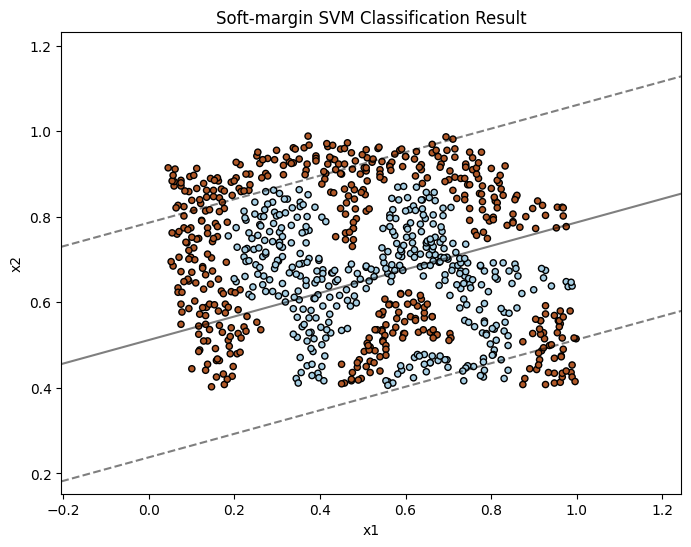

In [ ]:
plot(features, labels, dweights, dbias)

In [ ]:
# Assert that the primal and dual solutions are close
assert np.allclose(weights, dweights, rtol=1e-5, atol=1e-5), "Weights do not match"
assert np.allclose(bias, dbias, rtol=1e-5, atol=1e-5), "Bias does not match"

print("Primal and dual solutions match")

Primal and dual solutions match
